In [1]:
# Here we will explore trajectories wrt marks clusters
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd

from utils.plotting import (
    plot_divergence,
    build_vector_field,  # mine
    plot_vector_field,  # Lebedev's
    plot_occupancy_plot,
    plot_marks_clusters,
    plot_trajectory,
    plot_wall_sorted_samples
)
from utils.shapely_funcs import (
    marks2shapely,
    plot_intersected_element,
    plot_shapely_traj,
    plot_shapely_mark,
    find_traj_marks_intersections,
    extract_shapely_intersections,
)

In [2]:
DIR = 'preprocessed_dataset'

# load traj
fname = f'{DIR}/splited_isnear_marks.pkl'
with open(fname, 'rb') as f:
    traj_df = pickle.load(f)

# load marks
dfs_names = ['tr3','tr5','tr6','tr7', 'tr91']

marks_df = {}
for k in dfs_names:
    mname = f'{DIR}/marks_{k}_30bin_log.pkl'
    with open(mname, 'rb') as f:
        marks = pickle.load(f)
    marks_df[k] = marks

# 3 part divided trajectory
traj_df

# concated trajectory
traj_df_concat = {}
for k, traj_parts in traj_df.items():
    df = pd.concat(traj_parts)
    traj_df_concat[k] = df

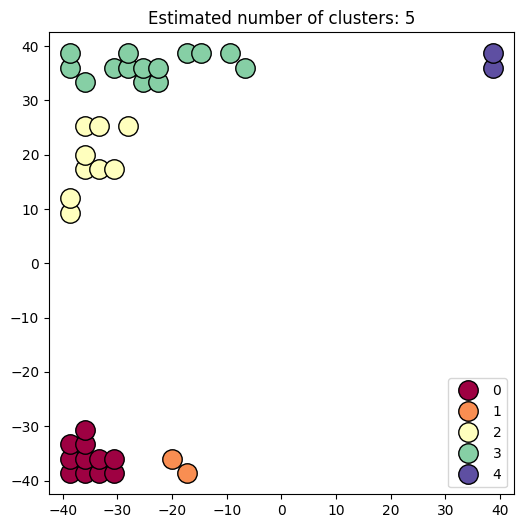

In [3]:
# open marks, classify them for center, walls, corners manually
m = marks_df['tr7']
X = m[['x', 'y']].to_numpy()
c = m['cluster'].to_numpy()
plot_marks_clusters(X, c)

# Classification:
# 'tr3' : wall=[3, 5, 7, 8, 9, 10, 12, 13], corner=[0, 11], 
#         center=[1, 2, 4, 6]
# Note: 1+2+4+6 ?, 5 + 3, 12 + 13, 7 + 8

# 'tr5' : wall=[2, 4, 5, 7, 11, 13], corner=[0, 1, 3, 9, 10, 12],
#         center=[6, 8]
# Note: 9 + 12, 0 + 1, 11 + 13?

# 'tr6' : wall=[2, 3, 4, 5, 6, 8], corner=[0, 1, 7], center=[]
# Note: 0 + 1, 5 + 8, 

# 'tr7' : wall=[1, 2, 3], corner=[0, 3, 4], center=[]
# Note: divide 3 cluster into 2 - wall\corner 

# 'tr91': wall=[], corner=[], center=[]
# Note: this is kind a control mice? Skip for now

For tr3


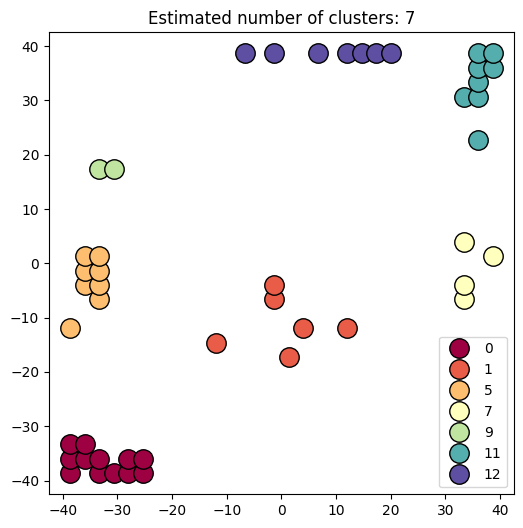

For tr5


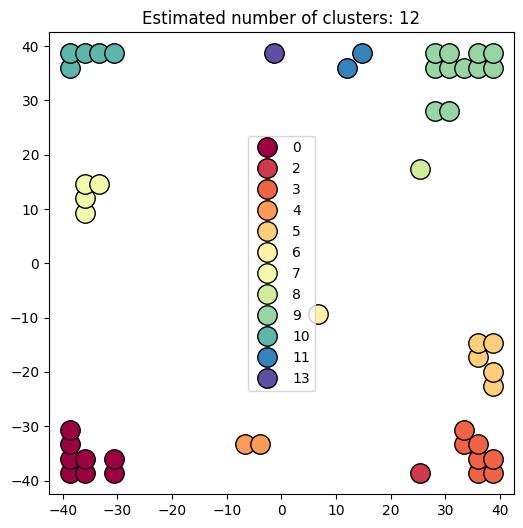

For tr6


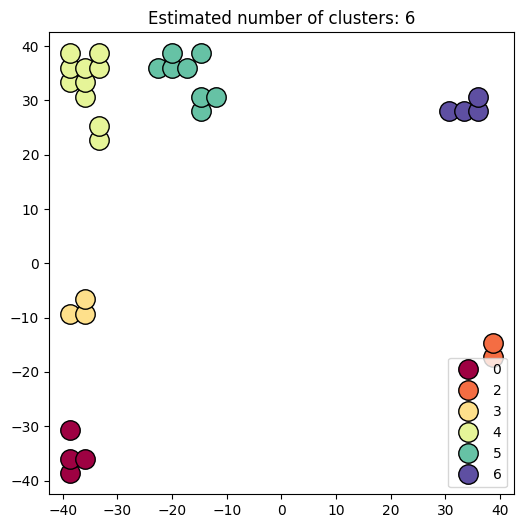

For tr7


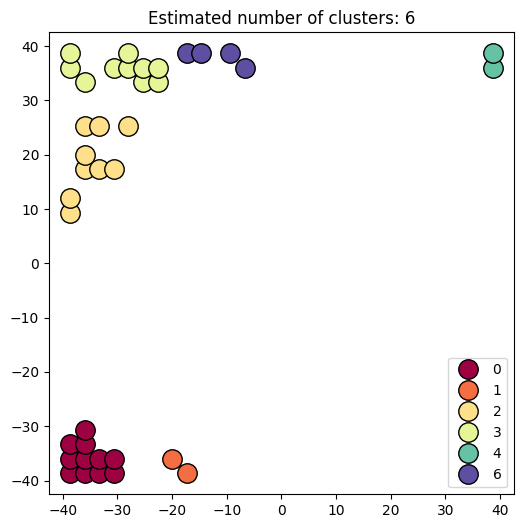

In [4]:
# Fix all marks manually
fixed_mark = {}
dfs_names = ['tr3','tr5','tr6','tr7']

# tr3: ========================================
m = marks_df['tr3']
m_ = m.copy()

i = m.loc[m['cluster']==3].index
m_.loc[i, 'cluster'] = 5

i = m.loc[(m['cluster']==1) | (m['cluster']==2) | (m['cluster']==4) | (m['cluster']==6)].index
m_.loc[i, 'cluster'] = 1

i = m.loc[m['cluster']==13].index
m_.loc[i, 'cluster'] = 12

i = m.loc[m['cluster']==8].index
m_.loc[i, 'cluster'] = 7

i = m.loc[m['cluster']==10].index
m_.loc[i, 'cluster'] = 11

X = m_[['x', 'y']].to_numpy()
c = m_['cluster'].to_numpy()
print('For tr3')
plot_marks_clusters(X, c)

fixed_mark['tr3'] = m_


# tr5: ========================================
m = marks_df['tr5']
# 9 + 12 
i = m.loc[m['cluster']==12].index
m_ = m.copy()
m_.loc[i, 'cluster'] = 9

# 0 + 1
i = m.loc[m['cluster']==1].index
m_.loc[i, 'cluster'] = 0

X = m_[['x', 'y']].to_numpy()
c = m_['cluster'].to_numpy()
print('For tr5')
plot_marks_clusters(X, c)
fixed_mark['tr5'] = m_

# tr6: ========================================
m = marks_df['tr6']
m_ = m.copy()

i = m.loc[m['cluster']==1].index
m_.loc[i, 'cluster'] = 0

i = m.loc[m['cluster']==7].index
m_.loc[i, 'cluster'] = 4
i = m.loc[m['cluster']==8].index
m_.loc[i, 'cluster'] = 5

X = m_[['x', 'y']].to_numpy()
c = m_['cluster'].to_numpy()
print('For tr6')
plot_marks_clusters(X, c)
fixed_mark['tr6'] = m_

# tr7: ========================================
m = marks_df['tr7']
m_ = m.copy()

i = m.loc[(m['cluster']==3) & (m['x'] > -20)].index
m_.loc[i, 'cluster'] = 6

X = m_[['x', 'y']].to_numpy()
c = m_['cluster'].to_numpy()
print('For tr7')
plot_marks_clusters(X, c)
fixed_mark['tr7'] = m_


savename = f'{DIR}/marks_all_fixed_30bin_log.pkl'
# with open(savename, 'wb') as fp:    # NOTE: uncomment to save
    # pickle.dump(fixed_mark, fp)

In [5]:
# Classification after fixing

# 'tr3' : wall=[0, 5, 7, 9, 12], corner=[0, 11], center=[1]
# 'tr5' : wall=[2, 4, 5, 7, 11, 13], corner=[0, 3, 9, 10], center=[6, 8]
# 'tr6' : wall=[2, 3, 4, 5, 6], corner=[0, 4], center=[]
# 'tr7' : wall=[1, 2, 6], corner=[0, 3, 4], center=[]

### Let's begin data analysis!

In [6]:
# Load fixed marks
with open(savename, 'rb') as f:
    marks_df_fixed = pickle.load(f)

In [7]:
from shapely.geometry import LineString, MultiLineString
from shapely.geometry import MultiPoint, Polygon, Point
from utils.plotting import plot_trajectory
import shapely
import matplotlib


def marks2shapely(df_marks, clust_labels, r=3.5, show=True):
    """
    df_marks: df with marks for a mice. clustered
    clust_labels: unique labels of clusters
    r: buffer zone radius

    return:
    marks_poly_list: a triplet of 
    [a marker cluster polygon, buffer zone and label of a cluster]
    """
    marks_poly_list = []
    # cmap = matplotlib.cm.get_cmap('tab20')
    cmap = matplotlib.colormaps.get_cmap('tab20')
    colors = cmap(clust_labels)

    for idx, lab in enumerate(clust_labels):
        points = df_marks[['x', 'y']].loc[df_marks['cluster']==lab].to_numpy()
        points = [(xy[0], xy[1]) for xy in points]

        if len(points) == 2:
            point1, point2 = points[0], points[1]
            point3, point4 = (point1[0], point2[1]), (point2[0], point1[1])
            convex_hull_polygon = Polygon([point1, point3,
                                           point2, point4])
        elif len(points) == 1:
            convex_hull_polygon = Point(points)
        else: 
            multi_point = MultiPoint(points)
            convex_hull_polygon = multi_point.convex_hull
            
        # Create a buffer
        zone_polygon = convex_hull_polygon.buffer(r)
        marks_poly_list.append([convex_hull_polygon, zone_polygon, lab])
        if show:
            x_zone, y_zone = zone_polygon.exterior.xy
            plt.fill(x_zone, y_zone, alpha=0.75, linewidth=1, linestyle='-',
                    edgecolor='black', label=lab, color=colors[idx])
            
            if type(convex_hull_polygon) == LineString:
                coord = shapely.get_coordinates(convex_hull_polygon)
                x, y = coord[:, 0], coord[:, 1]
            elif type(convex_hull_polygon) == Point:
                x, y = convex_hull_polygon.x, convex_hull_polygon.y
            else:
                x, y = convex_hull_polygon.exterior.xy

            plt.fill(x, y, alpha=0.5, linewidth=1, linestyle='-',
                    facecolor='none', edgecolor='black', label='')
            
    # color the points wrt mark strength
    x_, y_ = df_marks['x'], df_marks['y']
    color = df_marks['coeff'].to_numpy()
    plt.scatter(x_, y_, c=color, cmap='Greys', s=22)
    plt.colorbar()
    plt.legend()
    for vline in [-40, 40]:
        plt.axvline(vline, alpha=0.35, zorder=0, color='grey')     
        plt.axhline(vline, alpha=0.35, zorder=0, color='grey')     
    plt.show()
    
    return marks_poly_list

tr3 (47, 4)


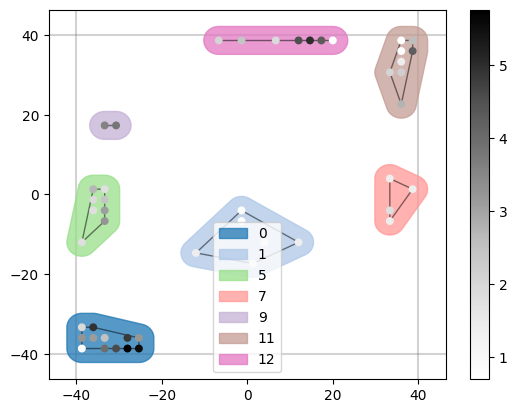

tr5 (48, 4)


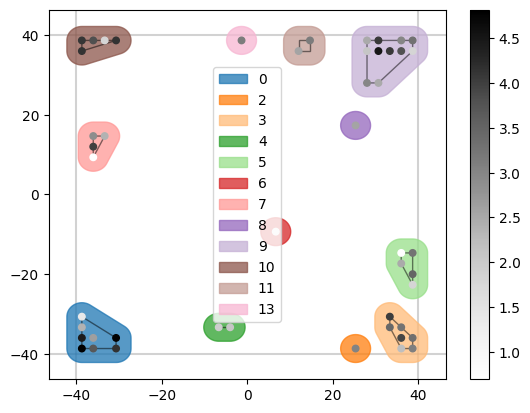

tr6 (31, 4)


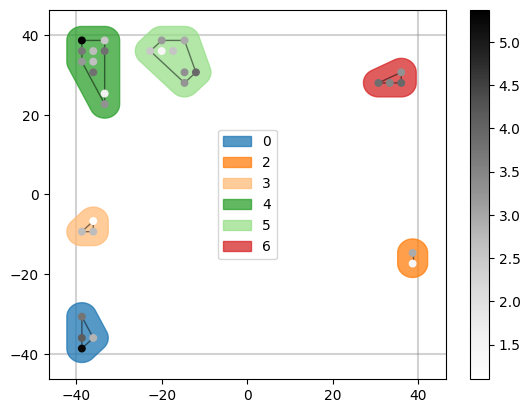

tr7 (38, 4)


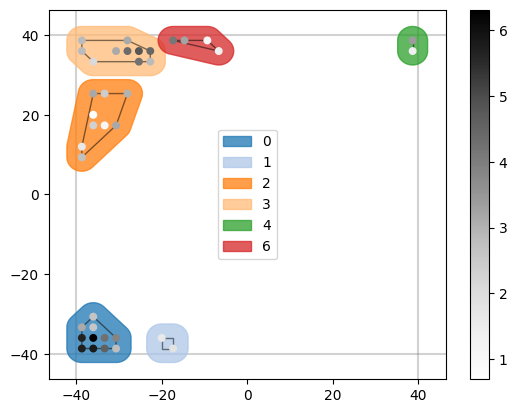

In [8]:
# Create poly from mark points

marks_poly_df = {}
for k, df in marks_df_fixed.items():

    print(k, df.shape)
    c = np.unique(df['cluster'].to_numpy())
    mpoly = marks2shapely(df, c, show=True)
    marks_poly_df[k] = mpoly

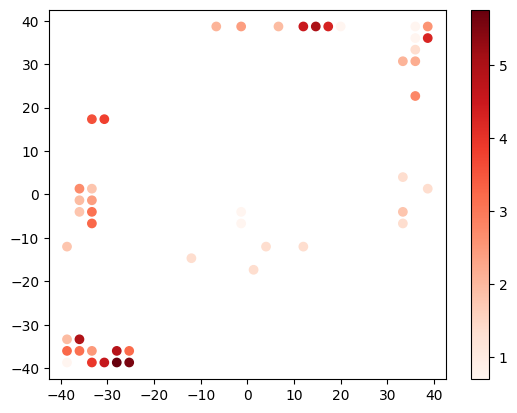

In [9]:
# extract strength wrt cluster - make heatmap-polygon
# plot
# strength of marks wrt area?

k = 'tr3'
# m = marks_poly_df[k]

df = marks_df_fixed[k]
c = np.unique(df['cluster'].to_numpy())

points = df #.loc[df['cluster']==lab] #.to_numpy()
x, y = points['x'], points['y']
color = points['coeff'].to_numpy()

plt.scatter(x, y, c=color, cmap='Reds')
plt.colorbar()
plt.show()

tr6
6


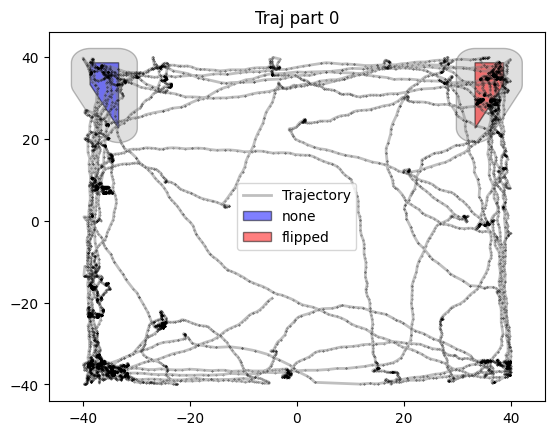

In [95]:
# Manually make polygons without marks for comparison
from utils.shapely_funcs import plot_shapely_mark, plot_shapely_traj

# Create affinity transform function
def move(poly, xmove, ymove): ### TODO:
    if type(poly) == LineString:
        coord = shapely.get_coordinates(poly)
    elif type(poly) == Point:
        coord = np.array([poly.x, poly.y])
    else:
        coord = np.asarray(poly.exterior.xy)

    xm, ym = coord[0, :] + xmove, coord[1, :] + ymove
    if (any(xm > 40) | any(xm < -40)) | (any(ym > 40) | any(ym < -40)):
        raise ValueError('Out of bounds, should be in range [-40, 40]')

    coordm = Polygon(np.stack([xm, ym]).T)
    return coordm


def vflip(poly):
    if type(poly) == LineString:
        coord = shapely.get_coordinates(poly)
    elif type(poly) == Point:
        coord = np.array([poly.x, poly.y])
    else:
        coord = np.asarray(poly.exterior.xy)

    if coord.shape[1] == 1:
        poly_f = Point(coord)
    elif coord.shape[1] == 2:
        poly_f = LineString(coord)
    else:
        coord = np.asarray(coord).T
        poly_f = Polygon(coord.dot([[1,0],[0,-1]]))
    return poly_f


def hflip(poly):
    if type(poly) == LineString:
        coord = shapely.get_coordinates(poly)
    elif type(poly) == Point:
        coord = np.array([poly.x, poly.y])
    else:
        coord = np.asarray(poly.exterior.xy)

    if coord.shape[1] == 1:
        poly_f = Point(coord)
    elif coord.shape[1] == 2:
        poly_f = LineString(coord)
    else:
        coord = np.asarray(coord).T
        poly_f = Polygon(coord.dot([[-1,0],[0,1]]))
    return poly_f


def to_shapely_traj(traj_df):
    points = traj_df[['x', 'y']].to_numpy()
    trajectory_points = [(xy[0], xy[1]) for xy in points]
    trajectory = LineString(trajectory_points)
    return trajectory


r = 3.5

k = 'tr6'
poly_list = marks_poly_df[k]

print(k)
print(len(poly_list))  # [poly, buffer, lab]
poly, buffer, lab = poly_list[3]

poly_f = hflip(poly)
buffer_f = hflip(buffer)
# poly_f = move(poly, 10, -20)

for i in range(3):
    traj = traj_df[k]
    traj_1part = traj[i]
    traj_1part = to_shapely_traj(traj_1part)

    plot_shapely_traj(traj_1part)
    plot_shapely_mark(poly, buffer)
    plot_shapely_mark(poly_f, buffer_f,
                    label='flipped', color='red')
    plt.title(f'Traj part {i}')
    plt.legend()
    plt.show()

    break

In [11]:
### Calculate coeff of strength of marks: 
# kappa_square = sum / square: the density of mark 
# kappa = sum / N_points:      the strength of mark

marks_coeffs = {}
for k, df in marks_df_fixed.items():
    kappas_dict = {}

    clust_labels = np.unique(df['cluster'].to_numpy())
    for idx, lab in enumerate(clust_labels):
        coeffs = df[['coeff']].loc[df['cluster']==lab].to_numpy()

        kappa = np.sum(coeffs) / coeffs.shape[0]
        
        poly_list = marks_poly_df[k]
        for l in poly_list:
            if l[2] == lab:
                sqrt = l[0].area
                if sqrt == 0:
                    kappa_square = None
                else:
                    kappa_square = np.sum(coeffs) / sqrt

        kappas_dict[lab] = [kappa, kappa_square]
    marks_coeffs[k] = kappas_dict

marks_coeffs['tr5']

{0: [3.538699951029691, 0.6634730667500599],
 2: [3.044522437723423, None],
 3: [3.3242475152622637, 1.0907141795547586],
 4: [2.0126758453675744, None],
 5: [2.3448834798127924, 0.8243318812624145],
 6: [1.0986122886681098, None],
 7: [2.4925995644546886, 1.4020171532718344],
 8: [2.5649493574615367, None],
 9: [3.144017912179322, 0.4228834388596147],
 10: [3.595912986921662, 1.6854999365692638],
 11: [2.850221786695343, 0.8015847977671865],
 13: [3.1354942159291497, None]}

### Now lets manually create pairs we want to compare for a trajectory

In [12]:
k = 'tr6'
poly_list = marks_poly_df[k]
# Labels notation: "mnk" - m=mouse idx, n=mark idx, k=flipped or not

comparison_list = []

# 0 -> hflip
poly, buffer, lab = poly_list[0]
poly_f = hflip(poly)
buffer_f = hflip(buffer)

comparison_list.append([[poly, buffer, 60],
                        [poly_f, buffer_f, 6011]])

# 3 -> vflip(hflip())
poly, buffer, lab = poly_list[3]
poly_f = vflip(hflip(poly))
buffer_f = vflip(hflip(buffer))

comparison_list.append([[poly, buffer, 63],
                        [poly_f, buffer_f, 6311]])

# 4 -> 
# poly, buffer, lab = poly_list[4]
# poly_f = vflip(hflip(poly))
# buffer_f = vflip(hflip(buffer))

# for i in range(3):
#     traj = traj_df[k]
#     traj_1part = traj[i]
#     traj_1part_traj = to_shapely_traj(traj_1part)

    # plot_shapely_traj(traj_1part_traj)
    # plot_shapely_mark(poly, buffer)
    # plot_shapely_mark(poly_f, buffer_f, 
    #                   label='flip', color='red')
    # plt.legend()
    # plt.show()

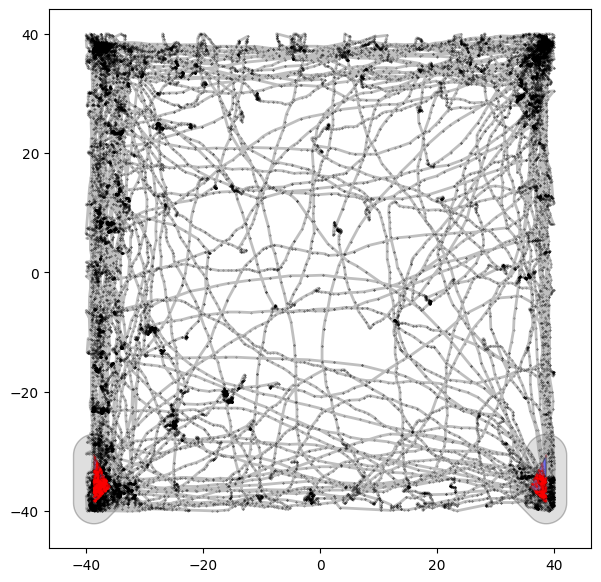

Unique intersecting points in DataFrame: 1451
Total ratio: 0.031


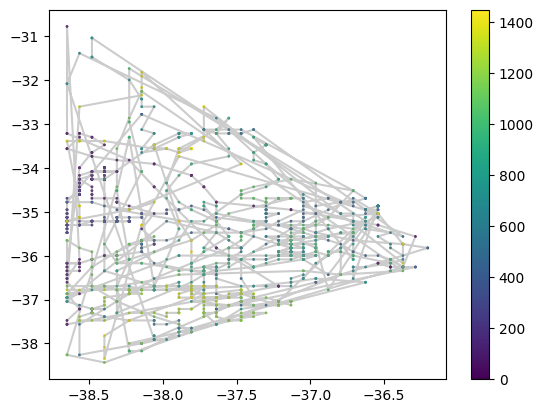

Unique intersecting points in DataFrame: 448
Total ratio: 0.01


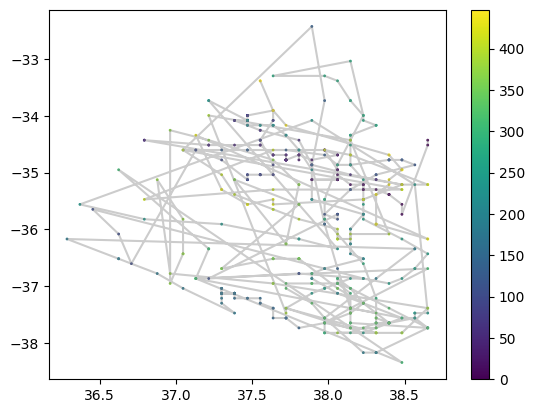

Unique intersecting points in DataFrame: 6552
Total ratio: 0.14


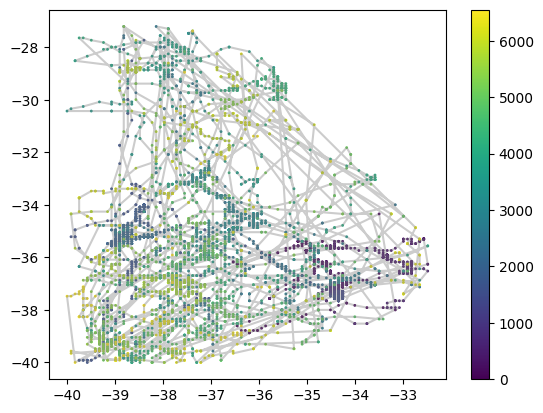

Unique intersecting points in DataFrame: 2184
Total ratio: 0.047


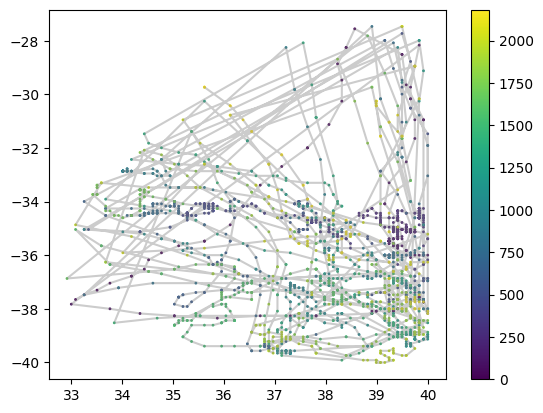

In [20]:
# Calculate trajectory parts intersected with marks

for comparison_pair in comparison_list:
    
    # Traj divided into 3 parts
    for i in range(3):
        i = 2
        traj = traj_df[k]
        # traj_1part = traj[i]
        traj_1part = pd.concat(traj)

        # for marks
        inters = find_traj_marks_intersections(tr=traj_1part.copy(),
                                               marks_poly_list=comparison_pair)
        df_inters, tr_new = extract_shapely_intersections(tr=traj_1part.copy(),
                                                          marks_interections=inters,
                                                          buff=False)
        df_inters_buff, tr_new_buff = extract_shapely_intersections(tr=traj_1part.copy(),
                                                                    marks_interections=inters,
                                                                    buff=True)
        break
    break

# форма распределения длинны шагов, форма распределения углов поворота
# количество сэмплов остановки, кол-во сэмплов бега

(1451,) (448,)
(6552,) (2184,)


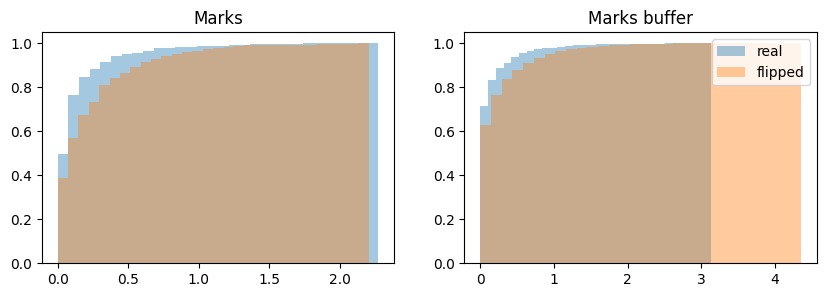

In [44]:
import scipy 
import seaborn as sns

m = tr_new['step_length'].loc[tr_new['intersection'] == 60]
m_f = tr_new['step_length'].loc[tr_new['intersection'] == 6011]

mbuff = tr_new_buff['step_length'].loc[tr_new_buff['intersection'] == 60]
mbuff_f = tr_new_buff['step_length'].loc[tr_new_buff['intersection'] == 6011]

# Number of samples
print(m.shape, m_f.shape)
print(mbuff.shape, mbuff_f.shape)

# Step len distributions
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].hist(m.to_numpy(), alpha=0.4, label='real',
           cumulative=True, density=True, bins=30)
ax[0].hist(m_f.to_numpy(), alpha=0.4, label='flipped',
           cumulative=True,  density=True, bins=30)

# cdf1 = scipy.stats.norm.cdf(m.to_numpy())
# cdf2 = scipy.stats.norm.cdf(m_f.to_numpy())
# sns.lineplot(x=m.to_numpy(), y=cdf1, ax=ax[0])
# sns.lineplot(x=m_f.to_numpy(), y=cdf2, ax=ax[0])

ax[0].set_title('Marks')

ax[1].hist(mbuff.to_numpy(), alpha=0.4, label='real',
           cumulative=True,  density=True, bins=30)
ax[1].hist(mbuff_f.to_numpy(), alpha=0.4, label='flipped',
           cumulative=True,  density=True, bins=30)
ax[1].set_title('Marks buffer')
plt.legend()
plt.show()

In [29]:
import numpy as np
from scipy.stats import mannwhitneyu

n1 = m.to_numpy() 
n2 = m_f.to_numpy()

# n1 = mbuff.to_numpy() 
# n2 = mbuff_f.to_numpy()
print(n1.shape, n2.shape)

U1, p = mannwhitneyu(n1, n2,)
print(U1, p)

(1451,) (448,)
260600.0 1.969967860919309e-11


In [23]:
# tr_new['movement']
# tr_new['V']
tr_new['V']

,index,time,x,y,step_length,near_wall,step_sum_0.5,movement,Vx,Vy,V,r1,r2,intersection
1,2,1.101,-4.641784,-18.934028,0.910170,0.0,-100.000000,NotDefined,-14.551627,-12.988245,19.606415,0,0,0.0
2,3,1.134,-5.316597,-19.542893,0.908894,0.0,-100.000000,NotDefined,-14.469954,-14.085143,20.341155,0,0,0.0
3,4,1.168,-5.316597,-19.542893,0.000000,0.0,-100.000000,NotDefined,-14.099087,-15.088203,20.827299,0,0,0.0
4,5,1.201,-5.823151,-20.239918,0.861651,0.0,-100.000000,NotDefined,-14.138622,-16.082558,21.615583,0,0,0.0
5,6,1.235,-6.328815,-21.023269,0.932381,0.0,-100.000000,NotDefined,-14.726862,-16.621348,22.476319,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46846,1029,1662.094,33.671185,19.890946,1.372376,2.0,7.964096,Move,-7.098607,-31.585002,32.668603,0,0,0.0
46847,1030,1662.127,33.671185,19.890946,0.000000,2.0,7.964096,Move,-4.652395,-31.411605,32.147686,0,0,0.0
46848,1031,1662.161,33.671185,19.890946,0.000000,2.0,7.964096,Move,-2.338164,-34.311988,34.730874,0,0,0.0
46849,1032,1662.194,33.755759,16.757545,3.134543,2.0,10.929491,Move,-0.750132,-40.223514,40.421515,0,0,0.0


In [25]:
# def add_angles(df):
#     dt = df['time'].diff()
#     vvx = df['x'].diff() / dt 
#     vvy = df['y'].diff() / dt 
#     dt[0], vvx[0], vvy[0] = 0., 0., 0.

#     Xx = np.arctan2(vvx, vvy)
#     Nres = normalize_angles_2pi(Xx)
#     ang = np.rad2deg(Nres) % 360
#     df['angles'] = ang
#     return df


# def add_delta_angles(df):
#     dangles = df['angles'].diff()
#     dangles[0] = 0.
#     dangles_rad = np.deg2rad(dangles)
#     normed_dangels_rad = normalize_angles_2pi(dangles_rad)
#     df['delta_angle'] = np.rad2deg(normed_dangels_rad) % 360
#     return df

from utils.processing import add_angles, add_delta_angles

tr_new_angles = add_angles(tr_new.copy())

In [28]:
tr_new_angles['angles']

m = tr_new['step_length'].loc[tr_new['intersection'] == 60]
m_f = tr_new['step_length'].loc[tr_new['intersection'] == 6011]

mbuff = tr_new_buff['step_length'].loc[tr_new_buff['intersection'] == 60]
mbuff_f = tr_new_buff['step_length'].loc[tr_new_buff['intersection'] == 6011]

# Number of samples
print(m.shape, m_f.shape)
print(mbuff.shape, mbuff_f.shape)

# Step len distributions
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].hist(m.to_numpy(), alpha=0.4, label='real')
ax[0].hist(m_f.to_numpy(), alpha=0.4, label='flipped')
ax[0].set_title('Marks')

ax[1].hist(mbuff.to_numpy(), alpha=0.4, label='real')
ax[1].hist(mbuff_f.to_numpy(), alpha=0.4, label='flipped')
ax[1].set_title('Marks buffer')
plt.legend()
plt.show()

# Angles distribution
m = tr_new['step_length'].loc[tr_new['intersection'] == 60]
m_f = tr_new['step_length'].loc[tr_new['intersection'] == 6011]

mbuff = tr_new_buff['step_length'].loc[tr_new_buff['intersection'] == 60]
mbuff_f = tr_new_buff['step_length'].loc[tr_new_buff['intersection'] == 6011]



1               NaN
2        227.940951
3          0.000000
4        216.007299
5        212.842841
            ...    
46846    197.907524
46847      0.000000
46848      0.000000
46849    178.453896
46850      0.000000
Name: angles, Length: 46850, dtype: float64

In [ ]:
# All trajectory together
for comparison_pair in comparison_list:

    traj = traj_df[k]
    traj_1part = pd.concat(traj)

    # for marks
    inters = find_traj_marks_intersections(tr=traj_1part.copy(),
                                            marks_poly_list=comparison_pair)
    df_inters, tr_new = extract_shapely_intersections(tr=traj_1part.copy(),
                                                        marks_interections=inters,
                                                        buff=False)
    df_inters_buff, tr_new_buff = extract_shapely_intersections(tr=traj_1part.copy(),
                                                                marks_interections=inters,
                                                                buff=True)

In [ ]:
# форма распределения длинны шагов, форма распределения углов поворота


In [ ]:
# stops = 2.5
# количество, частота, общий процент и длительность остановок